# Building a GAN to create fashion images



### In this workbook, we use a set of greyscale fashion images to teach a neural network what examples of "fashion" look like. After the training, the model will be able to produce entirely computer generated images of what it believes fashion is!

### The workbook is split into 8 stages:


#### 1. Setting up workbook for maximum speed
#### 2. Loading the required modules
#### 3. Setting seeds
#### 4. All the data stuff!
#### 5. Building the parts of the GAN
#### 6. Useful functions for training
#### 7. Actually training it!
#### 8. Let's make some new fashion images


A big thanks to machinelearningmastery for the idea for this workbook (https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/)




### 1. MAXIMUM SPEED

Google Colab generously gives you one GPU (graphics processing unit) to run computations on.
A GPU is much quicker than a CPU, in that it can perform many more FLOPs (floating point operations [read "calculations"]) per second.

To turn this feature on go to:
Edit > Notebook Settings > Change the hardware accelerator to GPU

In [0]:
# If this code runs and says "Found GPU ..." etc then congrats, you've turned the computation machine to full volume

import tensorflow as tf # Importing our first module (as below) but we need it 
                        # earlier to check whether we have the GPU running in the correct place!
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### 2. Loading the required modules

Python relies on loading in other modules and libraries that have special in-built functions for tasks that we want to perform. 

Keras (which is a higher-level abstraction of tensorflow) is a super easy API which has pre-programmed a lot of the dependancies and code necessary to completely build and train a neural net.

Next to each module I've included a comment about wtf it does.

In [0]:
import numpy as np   # Loading in numpy (a module for vector / array calculations) anc calling it "np"
import random 
import tensorflow as tf # Importing our first module (as below) but we need it 


from keras.models import Sequential, load_model # Keras holds all the tools, here we're accessing its "models" library 
                                                # and installing the "Sequential" model that allows us to stack all the layers 
                                                # in the CNN and it takes care of all the maths and setup. load_model allows us to
                                                # load previously saved models.


from keras.layers import Dense, Dropout, Flatten, Reshape, LeakyReLU
# Dense: the old fully-connected layer
# Dropout: randomly drops out some of the connections during each training phase (may be helpful in comp...)
# Reshape: reshapes an output to a different shape
# Flatten: transforms from high-dimension to a 1D vector
# LeakyRelu: An activation based upon Relu, that allos gradients to recover if they're accidentally crushed to zero.

from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose  
# Convolution2D: finds the 2D features (image to feature images)
# MaxPooling2D: reduces the dimensionality of the features
# Conv2DTranspose: otherwise known as a deconvolution - imagine mapping features to an image

from keras.optimizers import Adam
# This allows us to fine-tune the Adam optimiser in terms of its momentum / learning parameters

from keras.callbacks import ModelCheckpoint # Allows us to store versions of the model as it goes through its training, 
                                            # may be useful in competition time...


from keras.datasets import fashion_mnist	# The lovely people at Keras already have the data for us ready in a nice format, so might as well use it

from matplotlib import pyplot as plt  # Some plotting 

Using TensorFlow backend.


### 3. Setting the seeds 

So we can all get the same output

In [0]:
# SET RANDOM SEEDS
tf.set_random_seed(42)
random.seed(42)
np.random.seed(42)

### 4. Loading, analysing and preprocessing the data

#### Load:

In [0]:
# load the images into memory
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4423680/4422102 [==============================] - 1s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


#### Analyse (What an earth are we dealing with?):

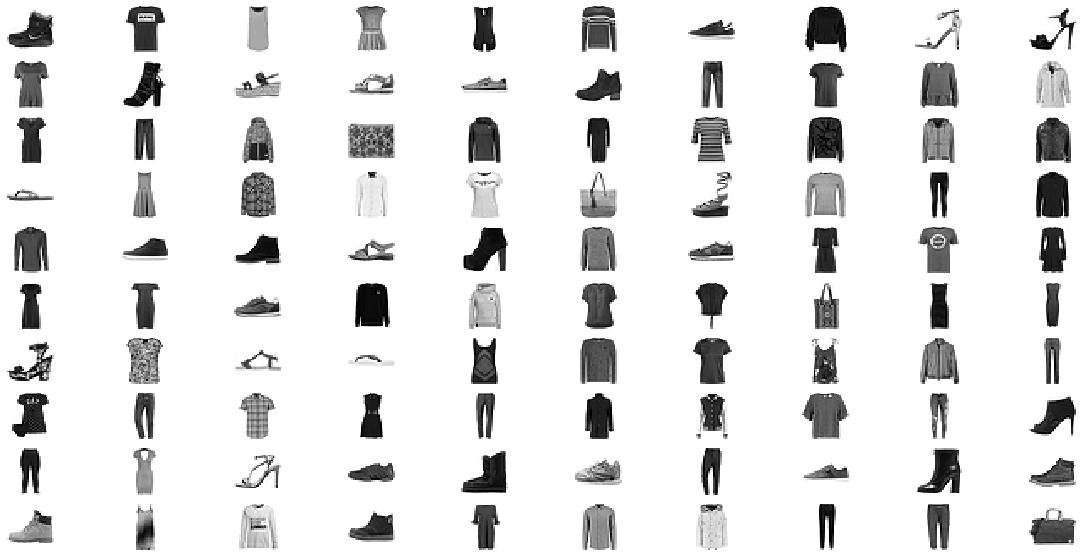

In [0]:
# plot images from the training dataset
plt.figure(figsize=(20,10))
for i in range(100):
	# define subplot
	plt.subplot(10, 10, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

Nice, we seem to have images in 28x28 greyscale of fashion products what are the y-labels though?

In [0]:
print(trainy[0:10])

[9 0 0 3 0 2 7 2 5 5]


AH, so they're categorical labels:

0: t-shirt

1: trouser

2: pullover

3: dress

4: coat

5: sandal

6: shirt

7: sneaker

8: bag

9: ankle boot


We won't need these though unless we do a conditional GAN.

#### Pre-process the image data:

Currently we have 60,000 lots of 28 by 28 greyscale images. We need to tell Keras that it'll be looking over 1 colour in the image (called the channel).

Greyscale is 1-channel, but a full colour RGB image is 3-channels.

Therefore we need to change the shape of the training data from (60000, 28, 28) to (60000, 28, 28, 1) .


And whilst we're here we'll also normalise the pixel values. Each pixel is normally in the range [0,255] representing how black/white it is. We'll change that so the value instead lies in [-1,1] which is easier to train on (less big numbers for multiplications, additions and gradients).

In [0]:
# The image data isn't quite in the format that the Keras CNN will want, so we want to change it:
trainX = trainX.reshape(trainX.shape[0], 28, 28, 1) # reshape it into 60,000 instances of 28 height x 28 width x 1 channel images

# Same for the test set
testX = testX.reshape(testX.shape[0], 28, 28, 1)

In [0]:
# Normalise:

trainX = trainX.astype('float32')
trainX = (trainX - 127.5) / 127.5 

# Same for the test set

testX = testX.astype('float32')
testX = (testX - 127.5) / 127.5 

### 5. Building discriminator, generator and combining to form the GAN

- Generator will take random noise inputs and will attempt to form them into images that resemble fashion-MNIST.

- Discriminator will aim to tell apart real from fake images. 

If the discriminator doesn't recognise a fake image, then the feedback to the generator will cause it to generate images more like the good forgery. Whereas if the discriminator correctly detects a fake photo, the generator is penalised, and will move away from generating images like the one that got caught.

This is much like an arms race between police and bank note forgery: as forgers get better, the police have to get better at detecting; and as th police get better, the forgers get better in order to continue their work.

#### Discriminator:

In [0]:
discriminator = Sequential()
# downsample
discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=(28,28,1))) # extract "features"
discriminator.add(LeakyReLU(alpha=0.2))
# downsample
discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) # more features
discriminator.add(LeakyReLU(alpha=0.2))
# classifier
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation='sigmoid')) # thinking layer
# compile model
opt = Adam(lr=0.0002, beta_1=0.5) # add the optimiser
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Generator:

In [0]:
generator = Sequential()
# foundation for 7x7 image
n_nodes = 128 * 7 * 7
generator.add(Dense(n_nodes, input_dim=100)) # takes a vector of length 100 of random noise and maps it to one of length 128*7*7 = 6272
generator.add(LeakyReLU(alpha=0.2))
generator.add(Reshape((7, 7, 128))) # Reshape into 128 lots of 7 by 7 pixel images.
# upsample to 14x14
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # looking over each 7 by 7 image and pad out each 4x4 box with some extra zeros around it to make a 14x14 image
generator.add(LeakyReLU(alpha=0.2))
# upsample to 28x28
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # Same idea as above
generator.add(LeakyReLU(alpha=0.2))
# generate
generator.add(Conv2D(1, (7,7), activation='tanh', padding='same')) # look over the 128 images and generate a single image from all their features.
print(generator.summary())
# Here we don't compile, as it's trained in the GAN, and not independently like the discriminator

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 128)      

#### GAN (Combined Generator and Discriminator):

In [0]:
discriminator.trainable = False # ie. let's us train the generator, without impacting the discriminator, which we train separately.
# connect them
GAN = Sequential()
# add generator
GAN.add(generator)
# add the discriminator
GAN.add(discriminator)
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
GAN.compile(loss='binary_crossentropy', optimizer=opt)

### 6. Useful functions! 
(Getting random noise for generator, generating fake images, getting real images)

#### Generate random noise:

In [0]:
def generate_latents(latent_dim=100, samples = 128): # We know our generator takes size 100 noise vectors as inputs. Here we generate 128 of them.
  
  noise = np.random.normal(0, 1, samples*latent_dim) # 12800 pieces of normal(0,1) noise
  noise = noise.reshape(samples, latent_dim) # reshape it into 128 instances of dim 100 noise.

  return noise

#### Generate a sample of the real images:

In [0]:
def generate_reals(dataset, samples = 64):
  # choose random indexes from the image set
	ix = np.random.randint(0, dataset.shape[0], samples) 
	# select these images
	X = dataset[ix]
	# generate class labels (as they are actual fashion images, they get a 1)
	y = np.ones((samples, 1))
	return X, y

#### Create a set of fake images using the generator:

In [0]:
def generate_fakes(generator, latent_dim = 100, samples = 64):
  
  # generate points in latent space ie. dim 100 noise
  noise = generate_latents(latent_dim, samples)
  # predict outputs ie. what does the generator map these to?
  X = generator.predict(noise)
  # create class labels. These are fake, and therefore get the label 0 for the discriminator.
  y = np.zeros((samples, 1))
  return X, y

### 7. Time to train the GAN! 

But first a useful training function:

#### Training Function:

In [0]:
def train(generator, discriminator, gan, dataset, latent_dim=100, n_epochs=100, n_batch=128):

	bat_per_epo = int(dataset.shape[0] / n_batch) # figure out the number of batches per epoch
	half_batch = int(n_batch / 2) # take half of this (for half real, half fake)
 
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_reals(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = discriminator.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fakes(generator, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latents(latent_dim, n_batch)
			# create inverted labels for the fake samples. This is important! Though the images are "fake" they are given the label 1. 
			# The classifier knows they're fake, and so will give a 0. This will cause a big loss, and therefore the generator has to update to find images that will fool the discriminator ie.
			# get a label of 1. In this way the generator improves.
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

#### Here we first train the discriminator to differentiate between real and fake fashion images by feeding it half-batches of the data.
#### The real images are sampled from the training set and have a value 1 for a true images.
#### The fake images are sampled from the generator as it currently is. ie. we use the generate_fakes() function to create noise vectos and transalte them to what it thinks are real images. We however label then as 0, so the discriminator learns that they're fake.

#### We then generate some noise vectors for our GAN and train the GAN with the label 1 for true label.
#### The idea here is that we map a noise vector to an image through the generator. As the discriminator just learnt that the generator images are fake, and so it will assign it a value close to zero. But as we have given it a true value of 1, then this creates a large error which is backpropogated through the network.

#### As the discriminator weights are held fixed in this backprop step, then it's forcing the generator to get better at producing images which will give a value 1 - ie. look more like the real training set.

#### Train time:

In [0]:
import time

start = time.time() # track how long it takes (this is the start point)

train(generator, discriminator, GAN, trainX) # use the above function to train.

print('')
print('Time to train = {}s'.format(time.time()-start)) # shows how long it took to train.

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/468, d1=0.695, d2=0.694 g=0.692
>1, 2/468, d1=0.631, d2=0.697 g=0.690
>1, 3/468, d1=0.568, d2=0.701 g=0.686
>1, 4/468, d1=0.504, d2=0.711 g=0.676


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>90, 152/468, d1=0.687, d2=0.694 g=0.706
>90, 153/468, d1=0.691, d2=0.687 g=0.701
>90, 154/468, d1=0.699, d2=0.697 g=0.699
>90, 155/468, d1=0.691, d2=0.688 g=0.703
>90, 156/468, d1=0.699, d2=0.690 g=0.709
>90, 157/468, d1=0.705, d2=0.692 g=0.704
>90, 158/468, d1=0.699, d2=0.690 g=0.704
>90, 159/468, d1=0.708, d2=0.699 g=0.704
>90, 160/468, d1=0.706, d2=0.692 g=0.706
>90, 161/468, d1=0.686, d2=0.689 g=0.704
>90, 162/468, d1=0.690, d2=0.688 g=0.706
>90, 163/468, d1=0.689, d2=0.704 g=0.703
>90, 164/468, d1=0.692, d2=0.677 g=0.702
>90, 165/468, d1=0.703, d2=0.694 g=0.706
>90, 166/468, d1=0.702, d2=0.687 g=0.702
>90, 167/468, d1=0.696, d2=0.679 g=0.713
>90, 168/468, d1=0.696, d2=0.699 g=0.705
>90, 169/468, d1=0.706, d2=0.697 g=0.701
>90, 170/468, d1=0.706, d2=0.706 g=0.706
>90, 171/468, d1=0.708, d2=0.683 g=0.712
>90, 172/468, d1=0.699, d2=0.695 g=0.703
>90, 173/468, d1=0.696, d2=0.689 g=0.701
>90, 174/468, d1=0.704, d2=0.696 g=0.700
>90, 1

### 8. Let's get it to make some images:

#### Here we generate 100 noise vectors and get the generator to convert them into what it's learnt to be "fashion images"

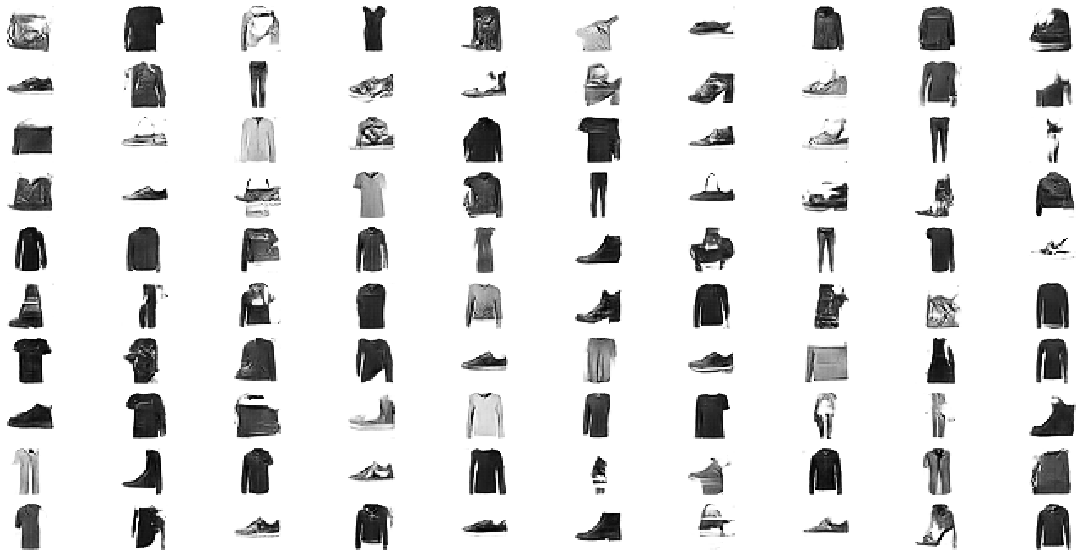

In [0]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
  plt.figure(figsize=(20,10))
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()
 
# generate noise vectors for the generator to create images from.
latent_points = generate_latents(100, 100)
# generate images
X = generator.predict(latent_points)
# plot the result
show_plot(X, 10)

#### A next step for this project could be a conditional GAN, which takes in the image and the label and attempts to classify the class of the image from the generator.

#### By doing so, we can then feed in noise vectors and categorical labels (say 0 corresponding to t-shirts) and the generator would output images that it thought were t-shirts!